# ALS Project

## Labs
- multi-subject
- make this tidy

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
#from functools import reduce
import pickle
from collections import defaultdict

In [86]:
from scipy.stats import linregress
from collections import defaultdict

### Functions

In [87]:
def linreg_scalers(df, subject_col, y_col, x_col, y_label):
    '''
    creates linear regression slopes, intercepts for every subject in a df.
    input:
        df = df
        subject_col = name of subject id column
        y_col = name of first y data column
        x_col = name of column with x values
        y_label = name of y feature (for table output)
    output:
        regression outputs in dataframe
    '''
    slopes = defaultdict()
    
    # list of every subject in table 
    subjects_list = list(np.unique(df[subject_col]))
    
    # for each subject
    for subj in subjects_list:
        data = df.loc[ df[subject_col]==subj].copy()
        y=data[y_col]
        x=data[x_col]

        # if only one record then skip
        if len(data)==1:
            continue
        # if missing values in x or y then skip
        if ~(y.isnull().any())  or (x.isnull().any()):
            y=np.array(y)
            x=np.array(x)
            # linregress is part of scipy.stats. 
            slope, intercept, r_value, p_value, std_err = linregress(x, y)
            slopes[subj] = (y_label, slope, intercept)

    # format as dataframe
    full_result = pd.DataFrame(slopes).transpose().reset_index()
    
    # relabel columns
    s_label = "slope_" + y_label 
    i_label = "intercept_" + y_label
    full_result.rename(index=str, columns={"index": "subject_id", 
                                      0: "test" ,1: s_label, 
                                      2: i_label }, inplace=True)
    
    # make small table
    mini_table = slope_mini_table(full_result.copy(), i_label)
    
    # return table
    return full_result, mini_table

In [88]:
def slope_mini_table(df, i_label):
    df.drop(['test', i_label], axis=1, inplace=True)
    df.dropna(axis=0, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [89]:
def make_lower(val):
    w=val.lower()
    return w

In [121]:
def plot_line_over_actuals(df_points, df_slope, subject_col, y_col_points, y_col_slope, y_col_inter, 
                           x_col, y_label, y_lim):
    subject_list = df_slope[subject_col].unique()
    df_slope.dropna(inplace=True)
    df_slope.reset_index(inplace=True)
    for subj in subject_list:
        points = df_points[ df_points[subject_col]==subj]
        line = df_slope[ df_slope[subject_col]==subj]
        points_data = np.all(~np.isnan(points[y_col].values))
        if points_data and line.shape[0]!=0:
            plt.figure(figsize=(8,4))
            plt.plot(points[x_col].values, points[y_col_points].values, label="actual")
            plt.plot(points[x_col].values,
                     line[y_col_inter].values + line[y_col_slope].values * points[x_col].values, 
                     '-', label="predicted") 
            plt.title("{} : {}".format(subj, y_label))
            plt.ylabel(y_label)
            plt.xlabel(x_col)
            plt.ylim(y_lim)
            plt.show()

## Load data

In [3]:
#load original csv file
labs = pd.read_csv("data/Labs.csv")

In [4]:
labs.head(20)

,subject_id,Test_Name,Test_Result,Test_Unit,Laboratory_Delta
0,329,Hemoglobin,130,g/L,0.0
1,329,Urine Color,YELLOW,NaN,0.0
2,329,Uric Acid,237.92,umol/L,0.0
3,329,ALPHA2-GLOBULIN,1,g/dL,0.0
4,329,Sodium,138,mmol/L,0.0
5,329,Glucose,-,NaN,0.0
6,329,Chloride,105,mmol/L,0.0
7,329,Bicarbonate,21,mmol/L,0.0
8,329,Segmented Neutrophils,66,%,0.0
9,329,Platelets,273,10E9/L,0.0


In [5]:
labs['study_day'] = labs["Laboratory_Delta"]
labs.drop("Laboratory_Delta", axis=1, inplace=True)

In [6]:
print(labs.shape)
labs.head()

(2445059, 5)


,subject_id,Test_Name,Test_Result,Test_Unit,study_day
0,329,Hemoglobin,130,g/L,0.0
1,329,Urine Color,YELLOW,NaN,0.0
2,329,Uric Acid,237.92,umol/L,0.0
3,329,ALPHA2-GLOBULIN,1,g/dL,0.0
4,329,Sodium,138,mmol/L,0.0


In [7]:
# make lowercase location column
labs['test_name'] = labs['Test_Name'].apply(make_lower)

In [8]:
# what do test look like?
#sorted(list(labs['test_name'].unique()))

In [9]:
# what are the common lab tests?
tests = labs['test_name'].value_counts(ascending=True)
x = tests[tests<100]

In [10]:
len(x) # number of tests less than 100

93

In [11]:
len(tests) # total number of tests

222

In [12]:
#list(x.index)  # see which tests are too uncommon

In [13]:
# get rid of any tests where less than 100 values exist.
labs = labs[ ~labs['test_name'].isin(list(x.index))]

In [14]:
# check few tests gone from dataset = yes
#labs['test_name'].value_counts(ascending=True)

In [15]:
labs.head()

,subject_id,Test_Name,Test_Result,Test_Unit,study_day,test_name
0,329,Hemoglobin,130,g/L,0.0,hemoglobin
1,329,Urine Color,YELLOW,NaN,0.0,urine color
2,329,Uric Acid,237.92,umol/L,0.0,uric acid
3,329,ALPHA2-GLOBULIN,1,g/dL,0.0,alpha2-globulin
4,329,Sodium,138,mmol/L,0.0,sodium


In [16]:
# there are missing samples
labs[ (labs['subject_id']==329) & (labs['study_day']==0)]['test_name'].value_counts()

protein                                      2
white blood cell (wbc)                       2
red blood cells (rbc)                        2
glucose                                      2
potassium                                    1
chloride                                     1
hemoglobin                                   1
ck                                           1
calcium                                      1
alt(sgpt)                                    1
uric acid                                    1
gamma-globulin                               1
albumin                                      1
lactate dehydrogenase                        1
mean corpuscular hemoglobin concentration    1
monocytes                                    1
blood urea nitrogen (bun)                    1
partial thromboplastin time                  1
urine squamous epithelial cells              1
immunoglobulin g                             1
alkaline phosphatase                         1
creatinine   

In [17]:
dups = ['red blood cells (rbc)', 'glucose', 'protein', 'white blood cell (wbc)']

In [18]:
labs[ (labs['subject_id']==329) & (labs['study_day']==0) & 
            (labs['test_name'].isin(dups))]

,subject_id,Test_Name,Test_Result,Test_Unit,study_day,test_name
5,329,Glucose,-,NaN,0.0,glucose
10,329,Red Blood Cells (RBC),2000,10E9/L,0.0,red blood cells (rbc)
11,329,Glucose,4.9395,mmol/L,0.0,glucose
25,329,Protein,70,g/L,0.0,protein
35,329,Protein,-,NaN,0.0,protein
37,329,White Blood Cell (WBC),10,10E9/L,0.0,white blood cell (wbc)
39,329,White Blood Cell (WBC),7.5,NaN,0.0,white blood cell (wbc)
49,329,Red Blood Cells (RBC),6000,10E9/L,0.0,red blood cells (rbc)


In [19]:
# replace the '-' with nans
labs['Test_Result'].replace('-', np.NaN, inplace=True)

In [20]:
labs[ (labs['subject_id']==329) & (labs['study_day']==0)]

,subject_id,Test_Name,Test_Result,Test_Unit,study_day,test_name
0,329,Hemoglobin,130,g/L,0.0,hemoglobin
1,329,Urine Color,YELLOW,NaN,0.0,urine color
2,329,Uric Acid,237.92,umol/L,0.0,uric acid
3,329,ALPHA2-GLOBULIN,1,g/dL,0.0,alpha2-globulin
4,329,Sodium,138,mmol/L,0.0,sodium
5,329,Glucose,NaN,NaN,0.0,glucose
6,329,Chloride,105,mmol/L,0.0,chloride
7,329,Bicarbonate,21,mmol/L,0.0,bicarbonate
8,329,Segmented Neutrophils,66,%,0.0,segmented neutrophils
9,329,Platelets,273,10E9/L,0.0,platelets


In [21]:
# remove old 'Test_Name'
labs.drop('Test_Name', axis=1, inplace=True)

In [22]:
print(labs.shape)
labs.head()

(2444028, 5)


,subject_id,Test_Result,Test_Unit,study_day,test_name
0,329,130,g/L,0.0,hemoglobin
1,329,YELLOW,NaN,0.0,urine color
2,329,237.92,umol/L,0.0,uric acid
3,329,1,g/dL,0.0,alpha2-globulin
4,329,138,mmol/L,0.0,sodium


In [23]:
# drop all observations from labs where 2 values are missing
labs.dropna(subset=['Test_Result'], inplace=True, how ='any', axis=0)

In [24]:
print(labs.shape)
labs.head(50)

(2394069, 5)


,subject_id,Test_Result,Test_Unit,study_day,test_name
0,329,130,g/L,0.0,hemoglobin
1,329,YELLOW,NaN,0.0,urine color
2,329,237.92,umol/L,0.0,uric acid
3,329,1,g/dL,0.0,alpha2-globulin
4,329,138,mmol/L,0.0,sodium
6,329,105,mmol/L,0.0,chloride
7,329,21,mmol/L,0.0,bicarbonate
8,329,66,%,0.0,segmented neutrophils
9,329,273,10E9/L,0.0,platelets
10,329,2000,10E9/L,0.0,red blood cells (rbc)


In [25]:
# there are missing samples
labs[ (labs['subject_id']==329) & (labs['study_day']==0)]['test_name'].value_counts()

white blood cell (wbc)                       2
red blood cells (rbc)                        2
potassium                                    1
mean corpuscular hemoglobin concentration    1
alkaline phosphatase                         1
ck                                           1
protein                                      1
calcium                                      1
alt(sgpt)                                    1
uric acid                                    1
gamma-globulin                               1
albumin                                      1
chloride                                     1
c-reactive protein                           1
hemoglobin                                   1
monocytes                                    1
blood urea nitrogen (bun)                    1
partial thromboplastin time                  1
urine squamous epithelial cells              1
immunoglobulin g                             1
bicarbonate                                  1
creatinine   

In [26]:
# drop the white blood cells without a unit.
labs.drop(labs[ (labs['test_name']=='white blood cell (wbc)') & 
               (pd.isna(labs['Test_Unit'])==True)].index, inplace=True)

In [27]:
print(labs.shape)
labs.head()

(2389662, 5)


,subject_id,Test_Result,Test_Unit,study_day,test_name
0,329,130,g/L,0.0,hemoglobin
1,329,YELLOW,NaN,0.0,urine color
2,329,237.92,umol/L,0.0,uric acid
3,329,1,g/dL,0.0,alpha2-globulin
4,329,138,mmol/L,0.0,sodium


In [28]:
labs[ (labs['subject_id']==329) & (labs['test_name']=='red blood cells (rbc)')]

,subject_id,Test_Result,Test_Unit,study_day,test_name
10,329,2000,10E9/L,0.0,red blood cells (rbc)
49,329,6000,10E9/L,0.0,red blood cells (rbc)
58,329,5000,10E9/L,42.0,red blood cells (rbc)
122,329,5000,10E9/L,72.0,red blood cells (rbc)
172,329,6000,10E9/L,106.0,red blood cells (rbc)
194,329,6000,10E9/L,135.0,red blood cells (rbc)
267,329,5000,10E9/L,168.0,red blood cells (rbc)
287,329,500,10E9/L,189.0,red blood cells (rbc)
311,329,5000,10E9/L,189.0,red blood cells (rbc)
340,329,5000,10E9/L,212.0,red blood cells (rbc)


In [29]:
# make a table of just 'red blood cells (rbc)'
red = labs[labs['test_name']=='red blood cells (rbc)']

In [30]:
red.head()

,subject_id,Test_Result,Test_Unit,study_day,test_name
10,329,2000,10E9/L,0.0,red blood cells (rbc)
49,329,6000,10E9/L,0.0,red blood cells (rbc)
58,329,5000,10E9/L,42.0,red blood cells (rbc)
122,329,5000,10E9/L,72.0,red blood cells (rbc)
172,329,6000,10E9/L,106.0,red blood cells (rbc)


In [31]:
# keep only red blood cell values with higher score
for subject in list(red['subject_id'].unique()):
    # index of all the redblood cells test results for this subject
    inx = list(red[ (red['subject_id']==subject) &
                (red['test_name']=='red blood cells (rbc)') ].index)
    if len(inx)>1:
        # unique days for this subject
        days=red.iloc[inx,3].unique()
        # for each unique day
        for d in days:
            # table of unique days
            near = red[ (red['subject_id']==subject) &
                        (red['study_day']== d) & 
                        (red['test_name']=='red blood cells (rbc)')]['Test_Result'].astype(float)
            # drop the row from labs table with lowest RBC value
            if len(near)>1:
                labs.drop(near.idxmin(), inplace=True)


IndexError: positional indexers are out-of-bounds

In [59]:
print(labs.shape)
labs.head()

(2389645, 5)


,subject_id,Test_Result,Test_Unit,study_day,test_name
0,329,130,g/L,0.0,hemoglobin
1,329,YELLOW,NaN,0.0,urine color
2,329,237.92,umol/L,0.0,uric acid
3,329,1,g/dL,0.0,alpha2-globulin
4,329,138,mmol/L,0.0,sodium


In [35]:
'''
#The onset data is being left off for now. The following works.

# add the onset data
tdrod = pd.read_csv("clean_data/tdrod.csv")
tdrod.head()
onset_dates = tdrod[['subject_id', 'Study_Arm', 'Onset_Delta']]
# merge onset data with labs
labs_onset = labs.merge(onset_dates, how='left', on='subject_id')
print(labs_onset.shape)
labs_onset.head()
labs_onset['days_from_onset'] = np.abs(labs_onset['Onset_Delta']) + labs_onset['study_day']
labs_onset.drop('Onset_Delta', axis=1, inplace=True)
print(labs_onset.shape)
labs_onset.head()
'''

In [61]:
#separate lab data into several smaller tables

lab_dfs=[]
for inx, t in enumerate(list(labs['test_name'].unique())):
    new_lab = labs[ labs['test_name'] == t].copy().reset_index(drop=True)
    new_lab[t]=new_lab['Test_Result']
    new_lab[t+' unit']=new_lab['Test_Unit']
    new_lab.drop(['test_name', 'Test_Unit', 'Test_Result'], axis=1, inplace=True)
    if inx == 0:
        final_lab = new_lab
    lab_dfs.append(new_lab)

In [65]:
lab_dfs[0].head()

,subject_id,study_day,hemoglobin,hemoglobin unit
0,329,0.0,130,g/L
1,329,42.0,120,g/L
2,329,72.0,120,g/L
3,329,106.0,120,g/L
4,329,135.0,120,g/L


In [66]:
# pickle the table list
with open('labs_list.pkl', 'wb') as f:
    pickle.dump(lab_dfs, f)

# Explore the data

In [67]:
# open the pickle file
with open('labs_list.pkl', 'rb') as f:
    labs_dfs = pickle.load(f)

In [131]:
len(labs_dfs)

128

In [136]:
for i in range(len(labs_dfs)):
    print(labs_dfs[i].columns[2])

hemoglobin
urine color
uric acid
alpha2-globulin
sodium
chloride
bicarbonate
segmented neutrophils
platelets
glucose
hematocrit
bilirubin (total)
immunoglobulin m
bilirubin (direct)
fibrinogen
absolute eosinophil count
alkaline phosphatase
immunoglobulin a
ast(sgot)
gamma-globulin
urine specific gravity
immunoglobulin g
monocytes
protein
urine squamous epithelial cells
mean corpuscular hemoglobin
mean corpuscular hemoglobin concentration
potassium
mean corpuscular volume
phosphorus
ck
free t4
lymphocytes
partial thromboplastin time
white blood cell (wbc)
c-reactive protein
lactate dehydrogenase
calcium
blood urea nitrogen (bun)
albumin/globulin ratio
urine appearance
albumin
basophils
beta-globulin
creatinine
red blood cells (rbc)
urine bacteria
alt(sgpt)
alpha1-globulin
prothrombin time (clotting)
urine mucus
urine uric acid crystals
urine calcium oxalate crystals
triglycerides
urine urobilinogen
globulin
urine protein
absolute basophil count
urine ph
urine blood
rbc morphology
biliru

## Individual Labs

In [502]:
num = 127
this=labs_dfs[num].copy()
val = this.columns[2]
val_name = "_".join(val.split())
print(val)
print(val_name)
print(this.shape)
this.head()

urine casts
urine_casts
(21, 4)


,subject_id,study_day,urine casts,urine casts unit
0,67104,224.0,2+,NaN
1,123093,154.0,1+,NaN
2,261892,181.0,1+,NaN
3,262033,0.0,1+,NaN
4,289895,0.0,1+,NaN


In [491]:
def is_not_num(nums):
    non_digs=[]
    for dig in nums:
        try:
            float(dig)
        except ValueError:
            non_digs.append(dig)
    return non_digs
wrong = is_not_num(list(this[val]))
which = set(wrong)
print(which)
print(len(wrong))

{'Normal'}
30


In [492]:
# remove row with wrong value
for word in which:
    this = this[ this[val]!=word]

In [493]:
this[val] = this[val].astype(float)
this.shape

(3717, 4)

In [494]:
labs_dfs[num] = this

In [508]:
updates = [4,6,8,15,20,23,34,35,38,39,42,44,45,47,57,61,68,69,70,85,87,92,113]

In [507]:
foo=['t','h','i','s']
foo[0]

't'

In [ ]:
update_dfs = labs_dfs[updates]

In [509]:
not_saved_list = []
for i in range(len(labs_dfs)):
    if i in updates:
        this=labs_dfs[i].copy()
        val = this.columns[2]
        val_name = "_".join(val.split())
        print(val)
        print(val_name)
        print(this.shape)
        print(this.head())
        response = input("float? (y/n): ")
        if response == 'y':
            try:
                this[val] = this[val].astype(float)

                # create linear regression lines for each subject's response
                df = this.copy()

                # the columns
                subject_col='subject_id'
                y_col=val
                x_col='study_day'
                y_label = y_col

                # the function
                full, mini = linreg_scalers(df, subject_col, y_col, x_col, y_label)

                print(mini.head())

                # save to csv
                saver = input("Save to File (y/n): ")
                if saver == 'y':
                    filename = 'clean_lab/lab_'+val_name+'_slope.csv'
                    mini.to_csv(filename, index=False)
                else:
                    not_saved_list.append(i)
            except:
                print("not saved: error")
                not_saved_list.append(i)
        else:
            not_saved_list.append(i)

sodium
sodium
(60265, 4)
   subject_id  study_day  sodium sodium unit
0         329        0.0   138.0      mmol/L
1         329       42.0   137.0      mmol/L
2         329       72.0   141.0      mmol/L
3         329      106.0   141.0      mmol/L
4         329      135.0   138.0      mmol/L


float? (y/n):  y


   subject_id slope_sodium
0         329   0.00612423
1         348  -0.00297742
2         533   0.00814153
3         649   0.00340341
4         708   -0.0193439


Save to File (y/n):  y


bicarbonate
bicarbonate
(54199, 4)
   subject_id  study_day  bicarbonate bicarbonate unit
0         329        0.0         21.0           mmol/L
1         329       42.0         21.0           mmol/L
2         329       72.0         25.0           mmol/L
3         329      106.0         23.0           mmol/L
4         329      135.0         21.0           mmol/L


float? (y/n):  y


   subject_id slope_bicarbonate
0         329         0.0161614
1         348       -0.00210248
2         533       -0.00757086
3         649        0.00641007
4         708        0.00621883


Save to File (y/n):  y


platelets
platelets
(58217, 4)
   subject_id  study_day platelets platelets unit
0         329        0.0       273         10E9/L
1         329       42.0       239         10E9/L
2         329       72.0       161         10E9/L
3         329      106.0        14         10E9/L
4         329      135.0        31         10E9/L


float? (y/n):  y


   subject_id slope_platelets
0         329        0.503324
1         348       0.0293509
2         533       0.0182815
3         649      0.00398754
4         708       -0.295242


Save to File (y/n):  y


absolute eosinophil count
absolute_eosinophil_count
(56310, 4)
   subject_id  study_day absolute eosinophil count  \
0         329        0.0                         7   
1         329       42.0                         1   
2         329       72.0                         5   
3         329      106.0                         0   
4         329      135.0                         9   

  absolute eosinophil count unit  
0                         10E9/L  
1                         10E9/L  
2                         10E9/L  
3                         10E9/L  
4                         10E9/L  


float? (y/n):  y


not saved: error
urine specific gravity
urine_specific_gravity
(24901, 4)
   subject_id  study_day  urine specific gravity urine specific gravity unit
0         329        0.0                     1.0                         NaN
1         329       42.0                     1.0                         NaN
2         329       72.0                     1.0                         NaN
3         329      106.0                     1.0                         NaN
4         329      135.0                     1.0                         NaN


float? (y/n):  y


   subject_id slope_urine specific gravity
0         329                            0
1         348                 -1.87607e-06
2         708                            0
3        1064                 -1.61531e-05
4        1736                 -1.20806e-05


Save to File (y/n):  y


protein
protein
(47651, 4)
   subject_id  study_day  protein protein unit
0         329        0.0     70.0          g/L
1         329       42.0     70.0          g/L
4         329       72.0     70.0          g/L
6         329      106.0     80.0          g/L
7         329      135.0     70.0          g/L


float? (y/n):  y


   subject_id slope_protein
0         329     0.0153609
1         348    0.00671193
2         533     0.0378923
3         649    0.00191672
4         708    0.00503018


Save to File (y/n):  y


white blood cell (wbc)
white_blood_cell_(wbc)
(63494, 4)
   subject_id  study_day  white blood cell (wbc) white blood cell (wbc) unit
0         329        0.0                    10.0                      10E9/L
1         329       42.0                    12.0                      10E9/L
2         329       72.0                     9.0                      10E9/L
3         329      106.0                     6.0                      10E9/L
4         329      135.0                    10.0                      10E9/L


float? (y/n):  y


   subject_id slope_white blood cell (wbc)
0         329                  -0.00934135
1         348                  -0.00218193
2         533                  -0.00651817
3         649                  -0.00339776
4         708                 -0.000607495


Save to File (y/n):  y


c-reactive protein
c-reactive_protein
(1966, 4)
   subject_id  study_day  c-reactive protein c-reactive protein unit
0         329        0.0                 1.0                    mg/L
1         329       42.0                 1.0                    mg/L
2         329      274.0                 2.0                    mg/L
3         708        0.0                 1.0                    mg/L
4         708       35.0                 1.0                    mg/L


float? (y/n):  y


   subject_id slope_c-reactive protein
0         329               0.00387253
1         708                        0
2        3981                -0.047619
3        5291                        0
4        6673                        0


Save to File (y/n):  y


blood urea nitrogen (bun)
blood_urea_nitrogen_(bun)
(58326, 4)
   subject_id  study_day  blood urea nitrogen (bun)  \
0         329        0.0                     2.9208   
1         329       42.0                     2.1906   
2         329       72.0                     1.8255   
3         329      106.0                     2.1906   
4         329      135.0                     1.8255   

  blood urea nitrogen (bun) unit  
0                         mmol/L  
1                         mmol/L  
2                         mmol/L  
3                         mmol/L  
4                         mmol/L  


float? (y/n):  y


   subject_id slope_blood urea nitrogen (bun)
0         329                     -0.00103121
1         348                     0.000660197
2         533                     -0.00259744
3         649                      0.00288149
4         708                      0.00236972


Save to File (y/n):  y


albumin/globulin ratio unit
albumin/globulin_ratio_unit
(1952, 4)
   subject_id  study_day albumin/globulin ratio unit  albumin_globulin_ratio
0         329        0.0                         NaN                     1.0
1         329       42.0                         NaN                     2.0
2         329      274.0                         NaN                     1.0
3         708        0.0                         NaN                     2.0
4         708       35.0                         NaN                     2.0


float? (y/n):  n


basophils
basophils
(45431, 4)
   subject_id  study_day  basophils basophils unit
0         329        0.0        1.0              %
1         329       42.0        1.0              %
2         329       72.0        1.0              %
3         329      106.0        2.0              %
4         329      135.0        1.0              %


float? (y/n):  y


   subject_id slope_basophils
0         329     -0.00178423
1         348    -0.000100205
2         533     0.000323378
3         708     0.000575521
4        1064      0.00124557


Save to File (y/n):  y


creatinine
creatinine
(61408, 4)
   subject_id  study_day  creatinine creatinine unit
0         329        0.0        88.4          umol/L
1         329       42.0        88.4          umol/L
2         329       72.0         0.0          umol/L
3         329      106.0         0.0          umol/L
4         329      135.0        88.4          umol/L


float? (y/n):  y


   subject_id slope_creatinine
0         329         0.135193
1         348      -0.00385162
2         533        -0.027914
3         649       -0.0119898
4         708                0


Save to File (y/n):  y


red blood cells (rbc)
red_blood_cells_(rbc)
(63903, 4)
   subject_id  study_day  red blood cells (rbc) red blood cells (rbc) unit
0         329        0.0                 6000.0                     10E9/L
1         329       42.0                 5000.0                     10E9/L
2         329       72.0                 5000.0                     10E9/L
3         329      106.0                 6000.0                     10E9/L
4         329      135.0                 6000.0                     10E9/L


float? (y/n):  y


   subject_id slope_red blood cells (rbc)
0         329                    -4.48158
1         348                    0.184799
2         533                     0.62393
3         649                    0.273242
4         708                     -6.8768


Save to File (y/n):  y


alt(sgpt)
alt(sgpt)
(73644, 4)
   subject_id  study_day  alt(sgpt) alt(sgpt) unit
0         329        0.0       18.0            U/L
1         329       42.0       49.0            U/L
2         329       72.0       29.0            U/L
3         329      106.0       21.0            U/L
4         329      135.0        9.0            U/L


float? (y/n):  y


   subject_id slope_alt(sgpt)
0         329      -0.0803522
1         348      -0.0239879
2         533       0.0122503
3         649     -0.00119164
4         708       0.0151234


Save to File (y/n):  y


absolute basophil count
absolute_basophil_count
(53904, 4)
   subject_id  study_day  absolute basophil count absolute basophil count unit
0         348        0.0                     0.05                       10E9/L
1         348       19.0                     0.05                       10E9/L
2         348       61.0                     0.03                       10E9/L
3         348       90.0                     0.05                       10E9/L
4         348      120.0                     0.03                       10E9/L


float? (y/n):  y


   subject_id slope_absolute basophil count
0         348                   -1.1523e-05
1         649                  -7.29693e-06
2        1064                   8.37228e-05
3        1234                  -4.01146e-06
4        1608                             0


Save to File (y/n):  y


bilirubin (indirect)
bilirubin_(indirect)
(6129, 4)
   subject_id  study_day  bilirubin (indirect) bilirubin (indirect) unit
0         348        0.0                  5.13                    umol/L
1         348       19.0                  5.13                    umol/L
2         348       61.0                  6.84                    umol/L
4         348      120.0                  5.13                    umol/L
6         348      201.0                  6.84                    umol/L


float? (y/n):  y


   subject_id slope_bilirubin (indirect)
0         348               -0.000232146
1        1064               -0.000694282
2        4877                0.000200397
3        5918                0.000251086
4        6502                 -0.0280393


Save to File (y/n):  y


gamma-glutamyltransferase
gamma-glutamyltransferase
(47555, 4)
   subject_id  study_day  gamma-glutamyltransferase  \
0         348        0.0                       20.0   
1         348       19.0                       19.0   
2         348       61.0                       21.0   
3         348       90.0                       19.0   
4         348      120.0                       20.0   

  gamma-glutamyltransferase unit  
0                            U/L  
1                            U/L  
2                            U/L  
3                            U/L  
4                            U/L  


float? (y/n):  y


   subject_id slope_gamma-glutamyltransferase
0         348                      0.00462878
1         649                     -0.00270529
2        1064                       0.0416796
3        1234                     -0.00278706
4        1608                       0.0122018


Save to File (y/n):  y


magnesium
magnesium
(7437, 4)
   subject_id  study_day  magnesium magnesium unit
0         348        0.0     0.8228         mmol/L
1         348       19.0     0.7817         mmol/L
2         348       61.0     0.7817         mmol/L
3         348       90.0     0.8228         mmol/L
4         348      120.0     0.8639         mmol/L


float? (y/n):  y


   subject_id slope_magnesium
0         348    -9.09684e-05
1        1064    -0.000164134
2        4877    -1.19132e-05
3        5918     0.000198891
4       11941     5.17059e-06


Save to File (y/n):  y


eosinophils
eosinophils
(39594, 4)
   subject_id  study_day  eosinophils eosinophils unit
0         348        0.0          1.0                %
1         348       19.0          0.9                %
2         348       61.0          1.0                %
3         348       90.0          1.3                %
4         348      120.0          1.6                %


float? (y/n):  y


   subject_id slope_eosinophils
0         348      -0.000649898
1         533        0.00533384
2        1064      -0.000819783
3        1736       0.000170962
4        2540         0.0193483


Save to File (y/n):  y


hba1c (glycated hemoglobin)
hba1c_(glycated_hemoglobin)
(22560, 4)
   subject_id  study_day  hba1c (glycated hemoglobin)  \
0         649      -17.0                          5.0   
1         649        0.0                          4.8   
2         649       32.0                          4.6   
3         649       61.0                          4.8   
4         649       95.0                          5.1   

  hba1c (glycated hemoglobin) unit  
0                                %  
1                                %  
2                                %  
3                                %  
4                                %  


float? (y/n):  y


   subject_id slope_hba1c (glycated hemoglobin)
0         649                       5.25085e-05
1        1234                      -0.000465144
2        2540                        0.00646293
3        2956                       8.82271e-05
4        3085                       0.000229555


Save to File (y/n):  y


absolute band neutrophil count
absolute_band_neutrophil_count
(4267, 4)
   subject_id  study_day  absolute band neutrophil count  \
0        1064      371.0                            0.14   
1        4796        0.0                            6.10   
2        4796      119.0                            7.00   
3        4796      148.0                            6.90   
4        4796      174.0                            7.50   

  absolute band neutrophil count unit  
0                              10E9/L  
1                              10E9/L  
2                              10E9/L  
3                              10E9/L  
4                              10E9/L  


float? (y/n):  y


   subject_id slope_absolute band neutrophil count
0        4796                           0.00247458
1        7036                            0.0101896
2        7795                         -8.52843e-05
3        8150                           0.00214861
4        8227                           -0.0001273


Save to File (y/n):  y


urine albumin
urine_albumin
(1500, 4)
   subject_id  study_day  urine albumin urine albumin unit
0        1736       -1.0        3.90000           mg/24hrs
1        1736        0.0        0.00039               g/dL
2        1736      103.0        3.80000           mg/24hrs
3        1736      104.0        0.00033               g/dL
4        2492        0.0        0.00000               g/dL


float? (y/n):  y


   subject_id slope_urine albumin
0        1736        -0.000836901
1        2492                   0
2        5658                   0
3        6786                   0
4        9494         -0.00543216


Save to File (y/n):  y


thyroid stimulating hormone
thyroid_stimulating_hormone
(3717, 4)
   subject_id  study_day  thyroid stimulating hormone  \
0        4796        0.0                         4.22   
1        4796      119.0                         4.00   
2        4796      148.0                         4.36   
3        4796      174.0                         4.10   
4        4796      230.0                         3.69   

  thyroid stimulating hormone unit  
0                              U/L  
1                              U/L  
2                              U/L  
3                              U/L  
4                              U/L  


float? (y/n):  y


   subject_id slope_thyroid stimulating hormone
0        4796                       -0.00172214
1        7036                       -0.00305125
2        7795                        0.00465969
3        8150                       -0.00328183
4        8227                        0.00196865


Save to File (y/n):  y


In [253]:
not_saved_list

[0,
 1,
 2,
 3,
 4,
 6,
 8,
 9,
 11,
 13,
 15,
 20,
 23,
 24,
 27,
 30,
 34,
 35,
 38,
 39,
 40,
 42,
 44,
 45,
 46,
 47,
 50,
 51,
 52,
 54,
 56,
 57,
 59,
 60,
 61,
 64,
 66,
 67,
 68,
 69,
 70,
 71,
 74,
 76,
 77,
 78,
 79,
 81,
 82,
 83,
 85,
 87,
 90,
 92,
 96,
 97,
 98,
 99,
 100,
 109,
 113,
 115,
 116,
 119,
 122,
 124,
 125,
 126,
 127]

In [235]:
# create linear regression lines for each subject's response
df = this.copy()

# the columns
subject_col='subject_id'
y_col=val
x_col='study_day'
y_label = y_col

# the function
full, mini = linreg_scalers(df, subject_col, y_col, x_col, y_label)

/Applications/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:127: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [236]:
full.head()

,subject_id,test,slope_partial thromboplastin time,intercept_partial thromboplastin time
0,329,partial thromboplastin time,-0.022754,33.188
1,533,partial thromboplastin time,NaN,NaN
2,708,partial thromboplastin time,-0.00340517,30.7359
3,1309,partial thromboplastin time,NaN,NaN
4,1736,partial thromboplastin time,NaN,NaN


In [237]:
mini.head()

,subject_id,slope_partial thromboplastin time
0,329,-0.022754
1,708,-0.00340517
2,3981,0.0545113
3,5291,-0.0851064
4,6673,-0.0697674


In [238]:
# save to csv
filename = 'clean_lab/lab_'+val_name+'_slope.csv'
mini.to_csv(filename, index=False)

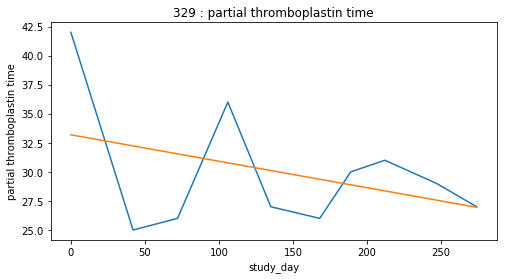

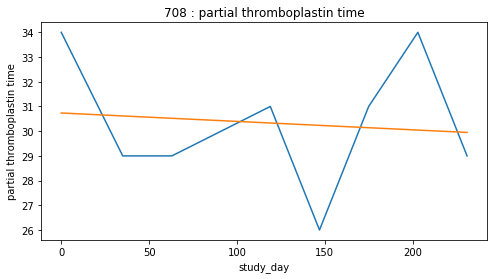

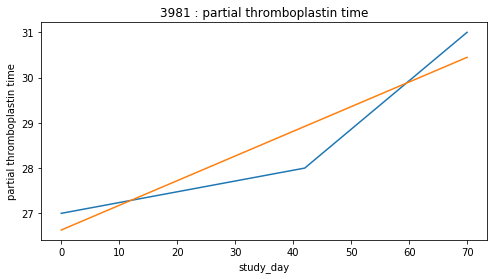

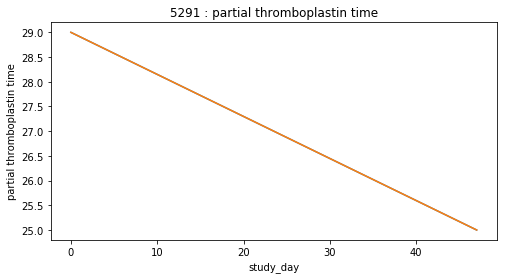

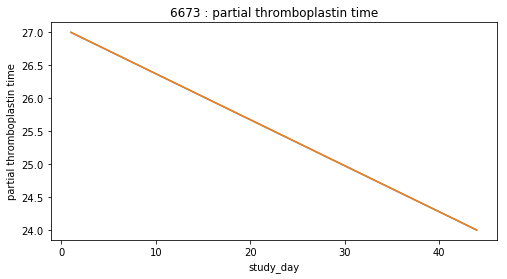

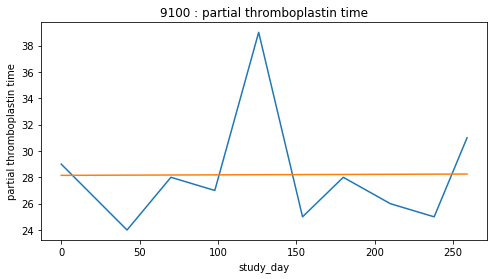

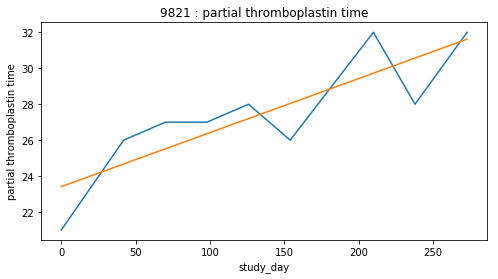

In [239]:
# plot the values over actuals
# plot a few subject's points with linear regression line
# note: only takes one assessment

# the dataframes
points=this
lines=full

#plot first few subjects data 
limit_subjects = lines['subject_id'].unique()[0:5]

# plot the actual points and the slope lines
df_points = points[ points['subject_id'].isin(limit_subjects)].copy()
df_slope = lines[ lines['subject_id'].isin(limit_subjects)].copy()

# the columns
subject_col = subject_col
x_col = x_col
y_col_points = y_col
y_col_slope = 'slope_'+y_col
y_col_inter = 'intercept_'+y_col
y_label = y_label
y_lim = None

plot_line_over_actuals(df_points, df_slope, subject_col, y_col_points, 
                       y_col_slope, y_col_inter, x_col, y_label, y_lim)

In [100]:
def plot_lab_result(df, subset_factor=None):
    '''
    subset_factor = string. column name
    '''
    if subset_factor!=None:
        f_list = list(df[subset_factor].unique())
    
    subjects = df['subject_id'].unique()
    test = df.columns[4]
    unit = df.iloc[0,5]

    print("Number of subjects: {}".format(len(subjects)))
    print("Number results in table: {}".format(len(df)))
    #f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,6))
    
    plt.figure(figsize=(12,6))
    # make a line for each subject
    for subject in subjects:
        sub = df[ df['subject_id'] == subject]
        '''
        # color by subset_factor
        #if np.any(sub[subset_factor]=='Yes'):
            #color = 'red'
        #else:
            #color = 'gray'
        '''
        color='gray'
        '''
        # if factor == to some value:
            ax1.plot(sub['days_since_onset'], sub['ALSFRS_Total'], color=color,
                     alpha=0.5, linewidth=1)
        else:
            ax2.plot(sub['days_since_onset'], sub['ALSFRS_R_Total'], color=color,
                     alpha=0.5, linewidth=1)
        '''
        plt.plot(sub['days_from_onset'], sub[test], color=color,
                     alpha=0.5, linewidth=1)
    
    # plotting particulars
    if subset_factor!=None:
        ax1.set_title("{} : {} ".format(test, ))
        ax2.set_title('Revised Function Assess')
    else:
        plt.title(test)
    plt.xlabel("days_from_onset")
    plt.ylabel(test+" "+unit)
    #plt.ylim(bottom=0, top=50)
    #plt.xlim(left=0, right=4000)
    plt.show()

## Last lab day for each subject

In [169]:
gr = labs_onset.groupby('subject_id').max()
max_lab_date = gr.drop(['Test_Result','test_name','Study_Arm'], axis=1)
max_lab_date['max_lab_date_onset'] = max_lab_date['days_from_onset']
max_lab_date['max_lab_study_day'] = max_lab_date['study_day']
max_lab_date.drop(['days_from_onset', 'study_day'], axis=1, inplace=True)
max_lab_date.reset_index(drop=False, inplace=True)
max_lab_date.head()

,subject_id,max_lab_date_onset,max_lab_study_day
0,329,1980.0,274.0
1,348,902.0,401.0
2,533,NaN,287.0
3,649,898.0,557.0
4,708,1301.0,231.0


In [170]:
# save to csv
filename = 'clean_data/max_lab_date.csv'
max_lab_date.to_csv(filename, index=False)

## Make one big labs table  
- actually don't

In [38]:
# open the pickle file
with open('labs_list.pkl', 'rb') as f:
    labs_dfs = pickle.load(f)

In [39]:
len(labs_dfs)

128

In [75]:
labs_dfs[0].head(10)

,subject_id,study_day,hemoglobin,hemoglobin unit
0,329,0.0,130,g/L
1,329,42.0,120,g/L
2,329,72.0,120,g/L
3,329,106.0,120,g/L
4,329,135.0,120,g/L
5,329,168.0,120,g/L
6,329,189.0,120,g/L
7,329,212.0,120,g/L
8,329,247.0,120,g/L
9,329,274.0,120,g/L


In [41]:
# get length of tables
table_len=[]
for i in range(len(labs_dfs)):
    table_len.append((i,len(labs_dfs[i])))
table_len=sorted(table_len, key=lambda x: x[1], reverse=True)

In [58]:
# get top 2 longest tables and merge
for i in range(3):
    inx = table_len[i][0]
    print(len(labs_dfs[inx]))
    if i ==0:
        new_table = labs_dfs[inx].copy()
    else:
        new_table = new_table.merge(labs_dfs[inx], how='outer', 
                                    on=['subject_id', 'study_day'])#,  indicator=True)

73646
70360
64655


In [59]:
print(new_table.shape)
new_table.head()

(91767, 8)


,subject_id,study_day,alt(sgpt),alt(sgpt) unit,ast(sgot),ast(sgot) unit,bilirubin (total),bilirubin (total) unit
0,329,0.0,18,U/L,20,U/L,0,umol/L
1,329,42.0,49,U/L,30,U/L,0,umol/L
2,329,72.0,29,U/L,21,U/L,17.104,umol/L
3,329,106.0,21,U/L,17,U/L,17.104,umol/L
4,329,135.0,9,U/L,10,U/L,17.104,umol/L


In [51]:
new_table['_merge'].value_counts()

both          73888
left_only      3354
right_only      103
Name: _merge, dtype: int64

In [73]:
# get top 2 longest tables and merge
for i in range(2,4):
    inx = table_len[i][0]
    print(len(labs_dfs[inx]))
    if i ==0:
        x = labs_dfs[inx].copy()
    else:
        new_table = x.merge(labs_dfs[inx], how='outer', 
                                    on=['subject_id', 'study_day'], indicator=True)
    

64655
64070


In [74]:
print(new_table.shape)
new_table.head()

(78052, 7)


,subject_id,study_day,alt(sgpt),alt(sgpt) unit,hemoglobin,hemoglobin unit,_merge
0,329,0.0,18,U/L,130,g/L,both
1,329,42.0,49,U/L,120,g/L,both
2,329,72.0,29,U/L,120,g/L,both
3,329,106.0,21,U/L,120,g/L,both
4,329,135.0,9,U/L,120,g/L,both


In [100]:
# get top 6 longest tables and merge
for i in range(5,6):
    inx = table_len[i][0]
    print(len(labs_dfs[inx]))
    if i ==0:
        new_table = labs_dfs[inx].copy()
    else:
        new_table = new_table.merge(labs_dfs[inx], how='outer', 
                                    on=['subject_id', 'study_day'])

63710


KeyboardInterrupt: 

In [ ]:
print(new_table.shape)
new_table.head()

In [3]:
for x in range(5,7):
    print(x)

5
6


In [98]:
sum((new_table['subject_id']==329) & (new_table['study_day']==0))

1

In [99]:
print(new_table.shape)
new_table.head(100)

(20811795, 16)


,subject_id,study_day,alt(sgpt),alt(sgpt) unit,ast(sgot),ast(sgot) unit,bilirubin (total),bilirubin (total) unit,hemoglobin,hemoglobin unit,red blood cells (rbc),red blood cells (rbc) unit,hematocrit_x,hematocrit unit_x,hematocrit_y,hematocrit unit_y
0,329,0.0,18,U/L,20,U/L,0,umol/L,130,g/L,6000,10E9/L,41,%,41,%
1,329,42.0,49,U/L,30,U/L,0,umol/L,120,g/L,5000,10E9/L,38,%,38,%
2,329,72.0,29,U/L,21,U/L,17.104,umol/L,120,g/L,5000,10E9/L,38,%,38,%
3,329,106.0,21,U/L,17,U/L,17.104,umol/L,120,g/L,6000,10E9/L,39,%,39,%
4,329,135.0,9,U/L,10,U/L,17.104,umol/L,120,g/L,6000,10E9/L,38,%,38,%
5,329,168.0,18,U/L,16,U/L,17.104,umol/L,120,g/L,5000,10E9/L,39,%,39,%
6,329,189.0,30,U/L,20,U/L,0,umol/L,120,g/L,5000,10E9/L,36,%,36,%
7,329,212.0,9,U/L,12,U/L,17.104,umol/L,120,g/L,5000,10E9/L,38,%,38,%
8,329,247.0,11,U/L,11,U/L,17.104,umol/L,120,g/L,6000,10E9/L,38,%,38,%
9,329,274.0,10,U/L,14,U/L,17.104,umol/L,120,g/L,5000,10E9/L,35,%,35,%


In [209]:
labs_final = reduce(lambda left,right: pd.merge(left,right,
                                              on=['subject_id','study_day'], 
                                              how='outer'), lab_dfs)

KeyboardInterrupt: 

In [210]:
# save to csv
filename = 'clean_data/labs_clean.csv'
labs_final.to_csv(filename, index=False)

NameError: name 'labs_final' is not defined